# Optimising a Decision Tree Classifier

Using findings from the _Decision Tree_ notebook to try and reduce RMSE

Initially, the decision tree classifier has an RMSE of 52.8 (3sf)

## Ideas

* Hyperparameter tuning: given so much data, easy to overfit. Reducing tree depth might make model generalise better
* Play with grid search and random search
* Feature importance: can see which features contribute least to the DT and remove them - might reduce noise in the model 


## Methodology

As this is a rough notebook, will train on $20,000$ rows sampled from the dataset to try to make things go a bit faster.

The same data cleaning assumptions will be made as in the `decision-tree.ipynb` 

## Preprocessing

Drop features and handle NaNs as per decision tree notebook (see there for more details).

In [23]:
import pandas as pd

df = pd.read_parquet("./data/rate_of_sale_may_2023.snappy.parquet")

TARGET = "days_to_sell"

columns_to_drop = [
    "stock_item_id",
    "last_date_seen",
    "last_retailer_asking_price",
    "generation",
    "derivative",
    "derivative_id",
    "first_registration_date",
    "attention_grabber",
    "postcode_area",
    "first_date_seen"
]

# drop excluded features
df = df.drop(columns_to_drop, axis=1)

# Replace missing values for specified columns with custom values
df['reviews_per_100_advertised_stock_last_12_months'] = df['reviews_per_100_advertised_stock_last_12_months'].fillna(0.0)
df['zero_to_sixty_mph_seconds'] = df['zero_to_sixty_mph_seconds'].fillna(-1)
df['advert_quality'] = df['advert_quality'].fillna(0.0)
df['colour'] = df['colour'].fillna("Black")


# drop EVs
excluded_fuel_types = ['Electric', 'Petrol Plug-in Hybrid', 'Diesel Plug-in Hybrid']
df = df[~df['fuel_type'].isin(excluded_fuel_types)]
df = df.drop(["battery_range_miles", "battery_usable_capacity_kwh"], axis=1)

# drop numerical outliers
numerical_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'days_to_sell']

means = df[numerical_features].mean()
stds = df[numerical_features].std()

# Define the upper and lower bounds for each feature
lower_bounds = means - 2 * stds
upper_bounds = means + 2 * stds

# Filter rows: keep only those within ±2 standard deviations from the mean for each numerical feature
filtered_indices = (df[numerical_features] >= lower_bounds) & (df[numerical_features] <= upper_bounds)
df = df[filtered_indices.all(axis=1)]
df = df[df["days_to_sell"] <= 100]  # only consider cars that were sold within 100 days - the rest skew the model to overestimate
# drop other NaNs
df = df.dropna()
df.sample(20_000)

,days_to_sell,first_retailer_asking_price,can_home_deliver,reviews_per_100_advertised_stock_last_12_months,segment,seats,doors,co2_emission_gpkm,top_speed_mph,zero_to_sixty_mph_seconds,...,transmission_type,drivetrain,colour,odometer_reading_miles,manufacturer_approved,price_indicator_rating,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality
105299,16,13000,False,4.7,Franchise,4.0,3.0,151.0,130.0,-1,...,Manual,Front Wheel Drive,Grey,20350,False,GOOD,13079.0,21110.0,19,50.0
96139,19,5440,False,7.5,Franchise,4.0,3.0,119.0,99.0,-1,...,Manual,Front Wheel Drive,Grey,46472,False,GOOD,5532.0,56099.0,29,67.0
68263,85,8495,False,0.0,Independent,5.0,5.0,124.0,115.0,13.4,...,Manual,Front Wheel Drive,Grey,72517,False,HIGH,7826.0,44532.0,25,0.0
67414,57,14999,False,0.0,Franchise,4.0,5.0,112.0,103.0,-1,...,Manual,Front Wheel Drive,Red,9324,False,GOOD,14091.0,16587.0,27,0.0
207887,55,22499,False,29.2,Independent,5.0,4.0,124.0,146.0,-1,...,Automatic,Four Wheel Drive,Grey,65000,False,GREAT,22004.0,59661.0,31,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46150,52,16495,False,0.5,Franchise,5.0,5.0,149.0,109.0,10.4,...,Manual,Front Wheel Drive,Red,23871,False,GOOD,16269.0,13445.0,40,42.0
170135,18,9399,True,17.5,Independent,5.0,5.0,101.0,111.0,-1,...,Manual,Front Wheel Drive,Purple,34312,False,GOOD,9153.0,48569.0,9,0.0
160953,51,28999,True,1.0,Franchise,5.0,5.0,136.0,127.0,7.9,...,Automatic,Four Wheel Drive,Blue,36959,True,GREAT,29485.0,51778.0,40,59.0
64961,64,37495,False,0.0,Franchise,5.0,5.0,189.0,155.0,-1,...,Automatic,Four Wheel Drive,White,31930,False,GOOD,37478.0,36611.0,55,49.0


## Encode the data

In [24]:
from sklearn.preprocessing import StandardScaler

binary_features = [
    "can_home_deliver",
    "manufacturer_approved"
]


categorical_features = [
    "segment",
    "make",
    "model",
    "body_type",
    "fuel_type",
    "transmission_type",
    "drivetrain",
    "colour",
    "price_indicator_rating",
]

df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    
numerical_features = [col for col in df_encoded.columns if col not in ('days_to_sell',) + tuple(categorical_features) + tuple(binary_features)]

scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])


## Training the Decision Tree

Training is done via k-fold cross-validation with `k=5`.
First, data is split into input features `X` and labels `y`

In [25]:

X = df_encoded.drop(TARGET, axis=1)
y = df_encoded[TARGET]

# one-hot encode categorical data
X = pd.get_dummies(X, drop_first=True)

## Hyperparameter tuning

Use a random search to get the optimal hyperparameter setup fot the decision tree

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint

model = DecisionTreeRegressor()

# setup random search
param_dist = {
    'max_depth': randint(3, 7),  
    'min_samples_split': randint(10, 20),  
    'min_samples_leaf': randint(10, 20),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    random_state=42,
    verbose=1
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)

Best parameters: {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 14}


Given the optimal set (`{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 14}`), run a 5 fold cv test on the model to get new RMSE

In [27]:
from sklearn.model_selection import cross_val_score
import numpy as np

k = 5

model = random_search.best_estimator_

# Perform k-fold CV and calculate MSE scores
cv_mse_scores = cross_val_score(model, X, y, cv=k, scoring='neg_mean_squared_error')

# Convert scores to positive MSE scores
cv_mse_scores_positive = -cv_mse_scores

# Calculate the average MSE and RMSE across all folds
average_cv_mse = np.mean(cv_mse_scores_positive)
average_cv_rmse = np.sqrt(average_cv_mse)

print(f"Average MSE across {k} folds: {average_cv_mse}")
print(f"Average RMSE across {k} folds: {average_cv_rmse}")

Average MSE across 5 folds: 526.2875447694037
Average RMSE across 5 folds: 22.940957799738957


## Results

Here a RMSE of 22.9 is seen (3sf). This is significantly better than the initial RMSE of 52.8, and thus hyperparameter optimisation and clipping training data to only samples within 100 days seems very worthwile.
 
## Feature Importance Analysis

Two features seem to be much more significant than the rest - `number_of_photos` and `advert_quality`. 
Since `advert_quality` missing values were dropped, this may have introduced bias into the model.
So in future, experiments should be done where imputation is done with interpolation or filling in with the median value, or something similar. 
  


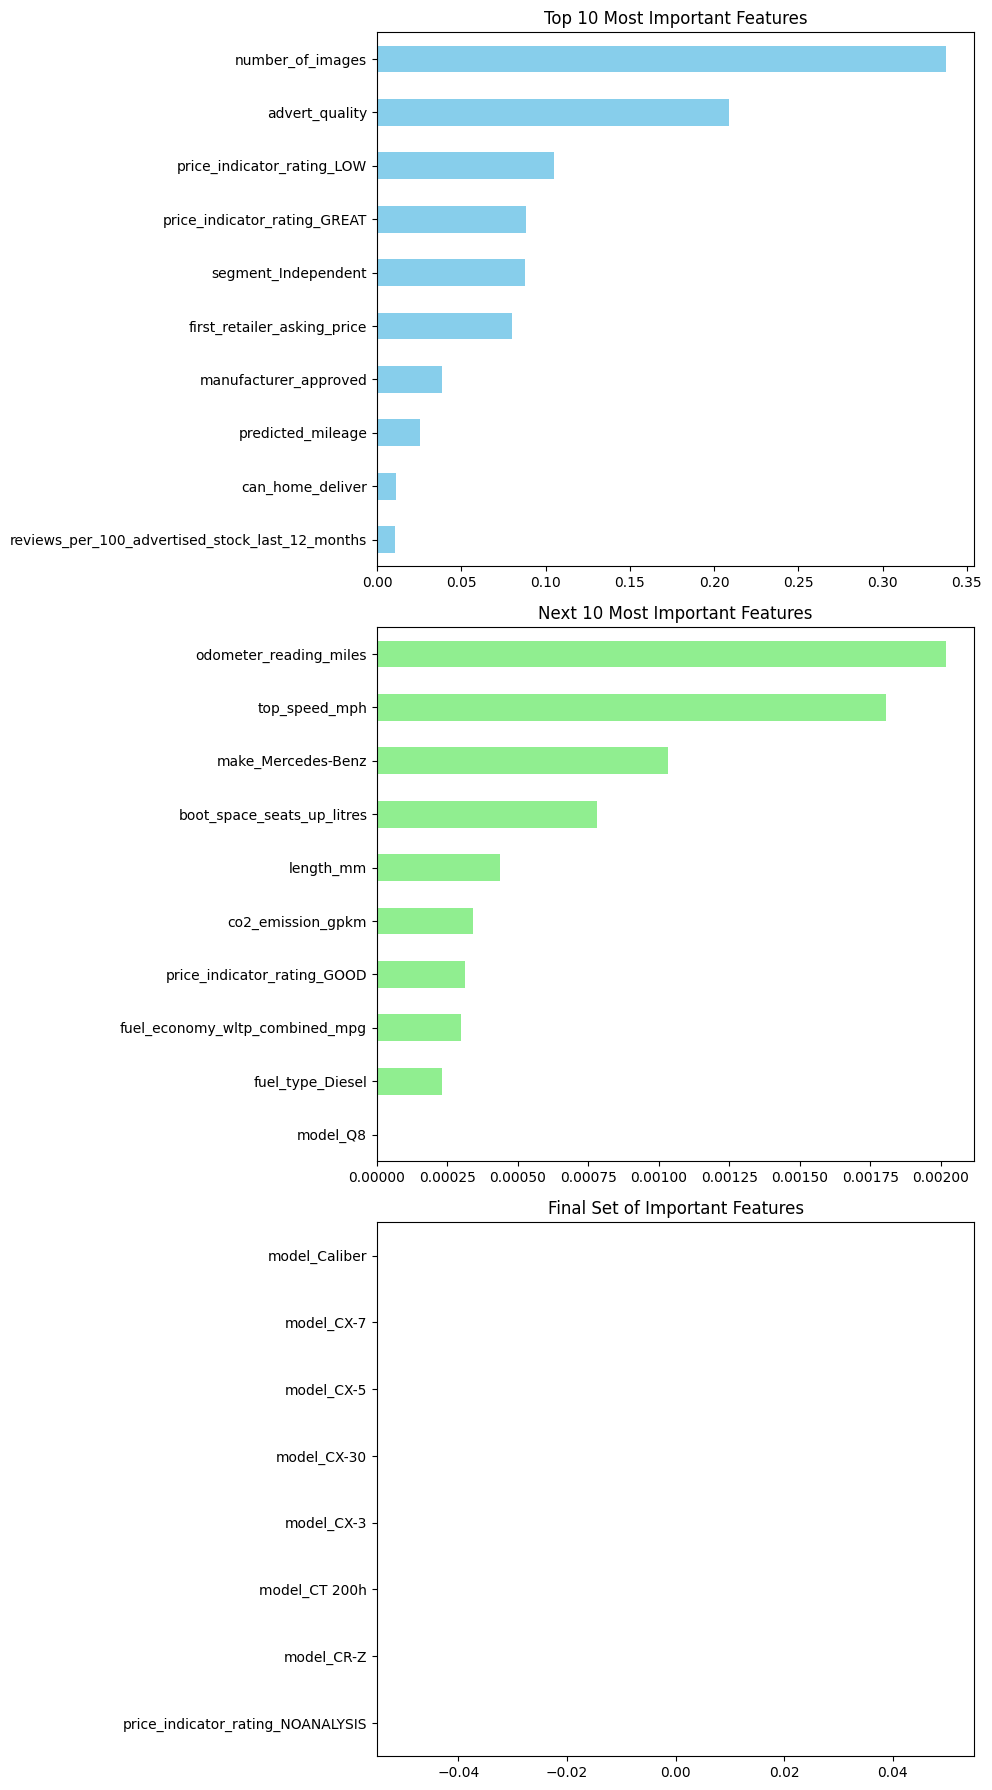

In [36]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
features = pd.Series(feature_importances, index=X.columns)
features_sorted = features.sort_values(ascending=False)

# Determine the total number of features to adjust the last plot
total_features = len(features_sorted)
last_plot_index = total_features - (total_features % 10 or 10)

# Setup the figure and axes for 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot the top 10 features
top_10_features = features_sorted.head(10)
top_10_features.plot(kind='barh', ax=axs[0], color='skyblue')
axs[0].set_title('Top 10 Most Important Features')
axs[0].invert_yaxis()

# Plot the next 10 most important features
next_10_features = features_sorted[10:20]
next_10_features.plot(kind='barh', ax=axs[1], color='lightgreen')
axs[1].set_title('Next 10 Most Important Features')
axs[1].invert_yaxis()

# Plot the final 10 features (or less, depending on the total feature count)
final_10_features = features_sorted[last_plot_index:]
final_10_features.plot(kind='barh', ax=axs[2], color='salmon')
axs[2].set_title('Final Set of Important Features')
axs[2].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()
